# Chapter 66: Deep Belief Networks

### Runs simulations for Examples 2 and 3 in Chapter 66: Deep Belief Networks (vol. III)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. scipy

The other ones are not necessary

In [22]:
import numpy as np
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
from functions import *

## Example 2 (Classification of handwritten digits)

We illustrate the operation of the autoencoder and contrastive divergence schemes by using them to determine initial parameter conditions for the training of a multi-layer neural network. The network will be used to identify handwritten digits using 
the same MNIST dataset from Example 65.9. Recall that the MNIST dataset consists of 60,000 labeled training samples and 10,000 labeled testing samples. Each entry in the dataset is a 28 $\times$ 28 grayscale image, which we transform into an $M=784-$long feature vector, $h_n$. Each pixel in the image and, therefore, each entry in $h_n$, assumes integer values in the range $[0,255]$. Every feature vector (or image) is assigned an integer label in the range $0$--$9$ depending on which digit the image corresponds to. The earlier Fig. 65.12 shows randomly selected images from the training dataset.
 
In the simulations in this example, we select only 5000 random samples from the training dataset and 1000 random samples from the test dataset. The objective is to illustrate the enhancement that is provided by the autoencoder and contrastive divergence constructions. For this purpose, it is not necessary to run a full-blown simulation using the entire dataset.
 
We use the 5000 training samples to train a neural network with $L=7$ layers (including the input layer, the output layer, and five hidden layers). The size of the input layer is $n_1=784$ (which agrees with the size of the feature vectors), while the size of the output layer is $n_7=10$ (which agrees with the number of classes). The size of the hidden layers is set to $n_{\ell}=128$ neurons for $\ell=2,3,4,5,6$ with sigmoidal activation functions. We employ a softmax layer at the output  and train  the network using a regularized cross-entropy criterion with parameters

$
\mu=0.01,\;\;\;\rho=0.0001 
$

We pre-process the images (or the corresponding feature vectors $\{h_n\}$ by scaling their entries by $255$ (so that they assume values in the range $[0,1]$). We subsequently compute the sample mean feature vectors for the training and test sets. We center the scaled feature vectors around these means in both sets. We train the network using $200$ passes over the data with random reshuffling.

In [ ]:
# testing initialization using autoencoders and contrastive divergence

# MNIST dataset
data = scipy.io.loadmat("data/mnist_normalized.mat") # loaded mnist data; features are centered and variance-normalized.
N_train = 60000 # using this many samples for training
N_test = 1000 # test samples
PP = np.random.permutation(N_train)
QQ = np.random.permutation(N_test)
features_train = data["train_features_norm"][PP] # random N_train feature vectors
labels_train = data["train_norm_labels"].reshape(-1)[PP]
features_test = data["test_features_norm"][QQ] # random N_test feature vectors
labels_test = data["test_norm_labels"].reshape(-1)[QQ] 
number_of_classes = 10 # 10 digit classes
M = features_train.shape[-1]
mu = 0.01 # step-size for training neural network
rho = 0.0001 # l2-regularization for neural network
number_of_passes = 30 # epochs
mu_ac = 0.001 # step-size for auto-encoder
rho_ac = 0 # l2-regularization for auto-encoder
passes_ac = 30 # number of autoencoder passes over data
mu_cd = 0.0001 # step-size for contrastive divergence
passes_cd = 30 # number of constrastive divergence passes over data
L = 7 # total number of layers, including input and output layers --> L-2 hidden layers
nL = number_of_classes # size of output layer, which is equal to the number of labels
n1 = features_train.shape[-1] # size of input layer, which is equal to M
n2 = 128 # number of nodes in hidden layer 2
n3 = 128 # number of nodes in hidden layer 3
n4 = 128
n5 = 128
n6 = 128
n7 = nL # same as output layer
Q = nL # size of output layer; same as nL, which the number of classes as well.

type_ = 1
if type_ == 1:
    activation = "sigmoid"
elif type_ == 2:
    activation = "tanh"
elif type_ == 3:
    activation = "rectifier"

# Initialization
H = features_train
flag = 0 # entries of feature vector are real-valued

error_test_init = np.zeros(3)
error_train_init = np.zeros(3)

for ix in range(3):
    CD = ix # type of initialization
            # 1: use contrastive divergence; 2: use autoencoders 3: use random initialization
    if CD == 0:
        print("Start Contrastive")
        # using constrastive divergence
        W1, theta1, theta_r1 = contrastive_divergence(H, n2, mu_cd, flag, passes_cd)
        H2 = forward(H, W1, theta1, 1) # using sigmoid function (type 1)

        W2, theta2, theta_r2 = contrastive_divergence(H2, n3, mu_cd, flag, passes_cd)
        H3 = forward(H2, W2, theta2, 1)

        W3, theta3, theta_r3 = contrastive_divergence(H3, n4, mu_cd, flag, passes_cd)
        H4 = forward(H3, W3, theta3, 1)

        W4, theta4, theta_r4 = contrastive_divergence(H4, n5, mu_cd, flag, passes_cd)
        H5 = forward(H4, W4, theta4, 1)

        W5, theta5, theta_r5 = contrastive_divergence(H5, n6, mu_cd, flag, passes_cd)
        H6 = forward(H5, W5, theta5, 1)

        W6 = (1/np.sqrt(n6))*np.random.randn(n7, n6)
        theta6 = np.random.randn(n7)

    elif CD == 1:
        # there are two types of activation functions in the auto-encoder implementation.
        # One is the activation function in the hidden layer, say, a sigmoid
        # The other is the activation function at the output, say, linear
        t_output = 4 # activation at output: 1=sigmoid, 2=tanh, 3 = rectifier, 4 =linear
        t_hidden = 1

        print("Start Auto Encoder")
        W1, theta1 = auto_encoder(H, t_hidden, t_output, n2, mu_ac, rho_ac, passes_ac)
        H2 = forward(H, W1, theta1, t_hidden)

        W2, theta2 = auto_encoder(H2, t_hidden, t_output, n3, mu_ac, rho_ac, passes_ac)
        H3 = forward(H2, W2, theta2, t_hidden)

        W3, theta3 = auto_encoder(H3, t_hidden, t_output, n4, mu_ac, rho_ac, passes_ac)
        H4 = forward(H3, W3, theta3, t_hidden)

        W4, theta4 = auto_encoder(H4, t_hidden, t_output, n5, mu_ac, rho_ac, passes_ac)
        H5 = forward(H4, W4, theta4, t_hidden)

        W5, theta5 = auto_encoder(H5, t_hidden, t_output, n6, mu_ac, rho_ac, passes_ac)
        H6 = forward(H5, W5, theta5, t_hidden)

        W6 = (1/np.sqrt(n6))*np.random.randn(n7, n6)
        theta6 = np.random.randn(n7)
    
    elif CD == 2:
        # random initialization
        print("Start Random Initialization")
        W1 = (1/np.sqrt(n1))*np.random.randn(n2, n1)
        W2 = (1/np.sqrt(n2))*np.random.randn(n3, n2)
        W3 = (1/np.sqrt(n3))*np.random.randn(n4, n3)
        W4 = (1/np.sqrt(n4))*np.random.randn(n5, n4)
        W5 = (1/np.sqrt(n5))*np.random.randn(n6, n5)
        W6 = (1/np.sqrt(n6))*np.random.randn(n7, n6)

        theta1 = np.random.randn(n2)
        theta2 = np.random.randn(n3)
        theta3 = np.random.randn(n4)
        theta4 = np.random.randn(n5)
        theta5 = np.random.randn(n6)
        theta6 = np.random.randn(n7)

    Wcell_init = [W1, W2, W3, W4, W5, W6] # a cell array containing the weight matrices of different dimensions
    ThetaCell_init = [theta1, theta2, theta3, theta4, theta5, theta6] # a cell array for the thetas

    layers = L # number of layers
    act = type_ # activation function type
    nc = number_of_classes # number of classes
    passes = number_of_passes 
    error_test = 0
    error_train = 0

    print("Start training")
    Wcell, ThetaCell, error_test, error_train = nn_entropy_softmax(layers,act,nc,passes,mu,rho,features_train,labels_train,features_test,labels_test,Wcell_init,ThetaCell_init)

    print("Type of initialization", CD)

    print("Performance on test data", N_test, error_test, 100*error_test/N_test)

    print("Performance on train data", N_train, error_train, 100*error_train/N_train)

    error_test_init[CD] = error_test 
    error_train_init[CD] = error_train

100*error_test_init/N_test, 100*error_train_init/N_train

In [21]:
100*error_test_init/N_test, 100*error_train_init/N_train

(array([7.7, 2.6, 3.3]), array([6.50666667, 1.84833333, 2.025     ]))

$
\begin{array}{|c|c|c|}
\hline
\textnormal{Initialization} & \textnormal{Empirical test error (\%)} & \textnormal{Empirical training error (\%)} \\ \hline 
\textnormal{Gaussian} & 87.4\% & 88.7\% \\
\textnormal{autoencoder} & 11.5\% & 0.00\% \\
\textnormal{contrastive divergene} & 16.6\% & 1.86\%\\ \hline 
\end{array}
$

We use three different initialization procedures for setting the parameters 
$\{W_{\ell},\theta_{\ell}\}$ before applying the backpropagation procedure (65.150) for cross-entropy risk minimization with a softmax output layer: (a) random Gaussian initial conditions as explained in  Section 65.5; (b) initial conditions obtained by means of the autoencoder structure using 

$
\mu_{\textnormal{ac}}=0.001,\;\;\;\rho_{\textnormal{ac}}=0\;\;\;(\textnormal{autoencoder training})
$

for the backpropagation iterations during the training of the individual autoencoder stages; and (c) initial conditions obtained by means of the contrastive divergence structure using 

$\mu_{\textnormal{cd}}=0.0001\;\;\;(\textnormal{contrastive divergence training})
$

for the backpropagation iterations during the training of the individual contrastive divergence stages. The training within the autoencoder and contrastive divergence stages employs 100 passes over the data with random reshuffling. The empirical errors rates are summarized in 
Table 66.1. These errors are computed over the 1000 test samples and 5000 training samples. 

## Example 3 (Generation of handwritten digits using a deep belief network)

We illustrate the operation of the deep belief network by applying it to the problem of learning to generate "handwritten digits" that are similar to the ones arising from the same MNIST dataset considered earlier in Examples 52.3 and 66.2. Recall that the MNIST dataset consists of 60,000 labeled training samples. Each entry in the dataset is a 28 $\times$ 28 grayscale image, which we transform into an $M=784-$long feature vector, $h_n$. Each pixel in the image and, therefore, each entry in $h_n$, assumes integer values in the range $[0,255]$. We transform these entries into binary values by thresholding all pixel values above 127 to 1 and all values less than or equal to 127 to 0.  For comparison purposes, Fig. 66.9 shows a random selection of eight images before and after transformation into the binary representation.

done transforming to binary features


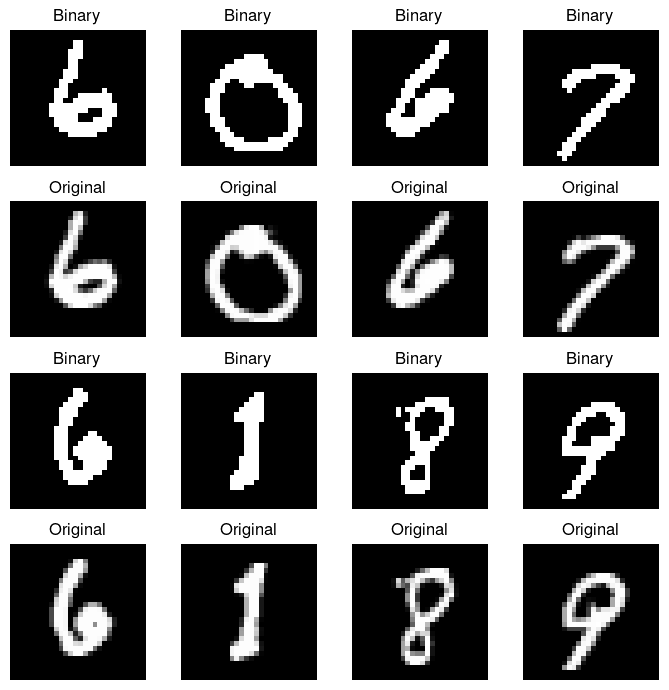

In [56]:
# MNIST dataset 
data = scipy.io.loadmat("data/mnist.mat")
train_features = data["trainX"] # 60,000 rows x 784 columns; each row is a training feature for one image
train_labels = data["trainY"] # 60,000 rows x 1   column; each row is the label 0-9
N = 60000 # using this many samples for training
M = 784

mu_cd = 0.0001 # step-size for contrastive divergence
passes_cd = 50 # number of contrastive divergence passes over data
L = 7 # total number of layers, including input and output layers --> L-2 hidden layers
nL = 10 # size of output layer, which is equal to the number of labels
n1 = M # size of input layer, which is equal to M
n2 = 128 # number of nodes in hidden layer 2 
n3 = 128 # number of nodes in hidden layer 3
n4 = 128
n5 = 128
n6 = 128
n7 = nL # same as output layer
Q = nL # size of output layer; same as nL, which the number of classes as well.
ITER = 100 # run this many Gibbs sampling iterations at last RBM during generation

type_ = 1  # use sigmoid activation function
flag = 1 # entries of feature vector are binary-valued

# transform features into binary vector
PP = np.random.permutation(N) # random permutation
H = np.zeros((N, M))
for n in range(N):
    nx = PP[n]
    hx = train_features[nx]
    y = hx > 127
    H[n] = y.copy() # transform to binary 0,1 entries: larger than 127 set to 1; smaller to zero

print("done transforming to binary features")

# displaysing some random images with integer and binary pixels
# figure 9 (images from MNIST)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for ib in range(8):
    n = np.random.randint(N)
    h = H[n] # image with binaty pixels 0,1
    hr = train_features[PP[n]] # original real image
    image_x = h.reshape((28, 28))
    image_r = hr.reshape((28, 28))

    if ib == 0:
        ax = fig.add_subplot(441)
        ax.imshow(image_x, cmap="gray") # show it in grayscale
        ax.set_title("Binary")
        plt.axis('off')        
        ax = fig.add_subplot(445)
        ax.imshow(image_r, cmap="gray") # show it in grayscale
        ax.set_title("Original")
        plt.axis('off') 
    if ib == 1:
        ax = fig.add_subplot(442)
        ax.imshow(image_x, cmap="gray") # show it in grayscale
        ax.set_title("Binary")
        plt.axis('off')        
        ax = fig.add_subplot(446)
        ax.imshow(image_r, cmap="gray") # show it in grayscale
        ax.set_title("Original")
        plt.axis('off') 
    if ib == 2:
        ax = fig.add_subplot(443)
        ax.imshow(image_x, cmap="gray") # show it in grayscale
        ax.set_title("Binary")
        plt.axis('off')        
        ax = fig.add_subplot(447)
        ax.imshow(image_r, cmap="gray") # show it in grayscale
        ax.set_title("Original")
        plt.axis('off') 
    if ib == 3:
        ax = fig.add_subplot(444)
        ax.imshow(image_x, cmap="gray") # show it in grayscale
        ax.set_title("Binary")
        plt.axis('off')        
        ax = fig.add_subplot(448)
        ax.imshow(image_r, cmap="gray") # show it in grayscale
        ax.set_title("Original")
        plt.axis('off') 
    if ib == 4:
        ax = fig.add_subplot(449)
        ax.imshow(image_x, cmap="gray") # show it in grayscale
        ax.set_title("Binary")
        plt.axis('off')        
        ax = fig.add_subplot(4, 4, 13)
        ax.imshow(image_r, cmap="gray") # show it in grayscale
        ax.set_title("Original")
        plt.axis('off') 
    if ib == 5:
        ax = fig.add_subplot(4, 4, 10)
        ax.imshow(image_x, cmap="gray") # show it in grayscale
        ax.set_title("Binary")
        plt.axis('off')        
        ax = fig.add_subplot(4, 4, 14)
        ax.imshow(image_r, cmap="gray") # show it in grayscale
        ax.set_title("Original")
        plt.axis('off') 
    if ib == 6:
        ax = fig.add_subplot(4, 4, 11)
        ax.imshow(image_x, cmap="gray") # show it in grayscale
        ax.set_title("Binary")
        plt.axis('off')        
        ax = fig.add_subplot(4, 4, 15)
        ax.imshow(image_r, cmap="gray") # show it in grayscale
        ax.set_title("Original")
        plt.axis('off') 
    if ib == 7:
        ax = fig.add_subplot(4, 4, 12)
        ax.imshow(image_x, cmap="gray") # show it in grayscale
        ax.set_title("Binary")
        plt.axis('off')        
        ax = fig.add_subplot(4, 4, 16)
        ax.imshow(image_r, cmap="gray") # show it in grayscale
        ax.set_title("Original")
        plt.axis('off') 

fig.tight_layout()

plt.savefig("figs/fig-9.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure 66.9** The top row shows four randomly selected images after pixel transformation to binary values along with the original images in the second row with pixel values in the range $[0,255]$. The same display is repeated in the last two rows for another collection of four random images.

We construct a deep belief network with seven total layers with sigmoidal units, including the last RBM layer, in a manner similar to Fig. 66.8. The signals at the successive layers are denoted by $\{h,z_{2},z_{3},\ldots, z_{7}\}$. The number of hidden units in each layer from left to right is

$
n_1=784,\;n_2=128,\;n_3=128,\;n_4=128,\;n_5=128,\;n_6=128,\;n_7=10
$

We set the step size for the contrastive divergence procedure to $\mu_{\textnormal{cd}}=0.0001$. Initially, we train each RBM separately, as explained before, using the binary-valued feature vectors from the MNIST dataset. Each RBM is trained for $1000$ iterations using binary data. Once training is complete, we generate 16 random vectors $\{z_7\}$ at the far right of the deep belief network, with binary entries. We propagate each vector $z_7$ through the network as follows. First, we perform 100 Gibbs sampling steps at the far-right RBM layer to determine $z_6$. Then, we propagate $z_6$ through the earlier sigmoidal sections, as described prior to the example. During these steps, we propagate the real-valued signals through the layers (i.e., the outputs of the sigmoidal units). In this way, we arrive at a feature vector $h$ for each $z_7$. Figure 66.10 shows 16 random images generated in this manner. The purpose of this example is to illustrate the general principle behind the operation of the network without focusing on perfecting its parameters or performance.

In [58]:
# run contrastive divergence to train RBMs
print("Start Contrastive")
# using constrastive divergence
W1, theta1, theta_r1 = contrastive_divergence(H, n2, mu_cd, flag, passes_cd)
H2x = forward(H, W1, theta1, 1) # using sigmoid function (type 1)
H2 = rand_bernoulli_matrix(H2x)
print("Done 1")

W2, theta2, theta_r2 = contrastive_divergence(H2, n3, mu_cd, flag, passes_cd)
H3x = forward(H2, W2, theta2, 1)
H3 = rand_bernoulli_matrix(H3x)
print("Done 2")

W3, theta3, theta_r3 = contrastive_divergence(H3, n4, mu_cd, flag, passes_cd)
H4x = forward(H3, W3, theta3, 1)
H4 = rand_bernoulli_matrix(H4x)
print("Done 3")

W4, theta4, theta_r4 = contrastive_divergence(H4, n5, mu_cd, flag, passes_cd)
H5x = forward(H4, W4, theta4, 1)
H5 = rand_bernoulli_matrix(H5x)
print("Done 4")

W5, theta5, theta_r5 = contrastive_divergence(H5, n6, mu_cd, flag, passes_cd)
H6x = forward(H5, W5, theta5, 1)
H6 = rand_bernoulli_matrix(H6x)
print("Done 6")

W6, theta6, theta_r6 = contrastive_divergence(H6, n7, mu_cd, flag, passes_cd)
H7x = forward(H6, W6, theta6, 1)
H7 = rand_bernoulli_matrix(H7x)
print("Done RBM")

# Now we test the deep belief network as a generative model
# We feed a random binary-valued vector and see the image that is generated

Start Contrastive


100%|██████████| 50/50 [2:04:54<00:00, 149.89s/it]  


Done 1


100%|██████████| 50/50 [40:17<00:00, 48.35s/it]


Done 2


100%|██████████| 50/50 [40:36<00:00, 48.73s/it]


Done 3


100%|██████████| 50/50 [40:59<00:00, 49.19s/it]


Done 4


100%|██████████| 50/50 [40:44<00:00, 48.88s/it]


Done 6


100%|██████████| 50/50 [14:44<00:00, 17.70s/it]


Done RBM


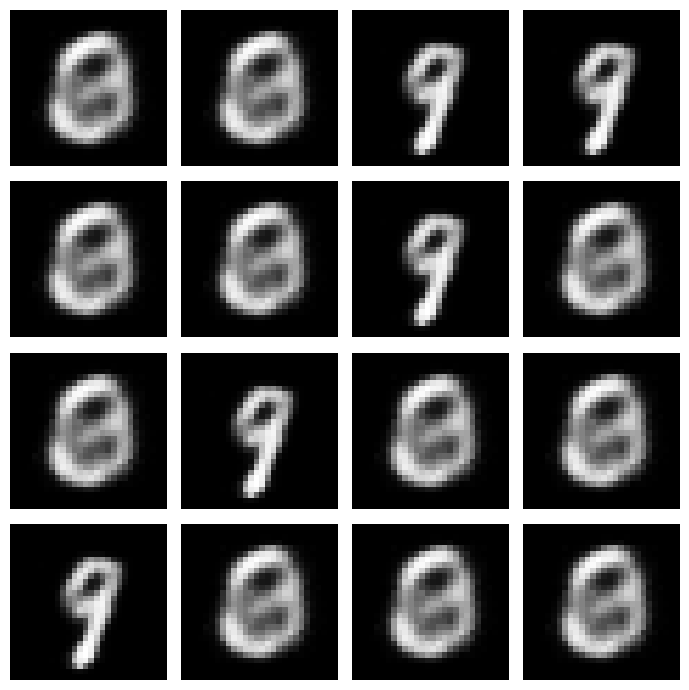

In [61]:
# figure 10 (generated figures)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for ib in range(16):
    z7 = np.zeros(n7)
    for n in range(n7):
        z7[n] = np.random.randint(2)
    for i in range(ITER): # last RBM; several Gibbs sampling steps
        z6y = W6.T@z7 - theta_r6
        z6 = apply_activation(1, z6y) # sigmoid
        z6b = rand_bernoulli(z6)
        xp = W6@z6b - theta6 
        z7x = apply_activation(1, xp)
        z7 = rand_bernoulli(z7x)

    # use the resulting z6 propagate it through sigmoidal sections without binary transformations
    z5y = W5.T@z6 - theta_r5 
    z5 = apply_activation(1, z5y)

    z4y = W4.T@z5 - theta_r4 
    z4 = apply_activation(1, z4y)

    z3y = W3.T@z4 - theta_r3
    z3 = apply_activation(1, z3y)

    z2y = W2.T@z3 - theta_r2 
    z2 = apply_activation(1, z2y)

    z1y = W1.T@z2 - theta_r1 
    hx = apply_activation(1, z1y) # real valued between (0, 1)
    hb = rand_bernoulli(hx) # binary pixels {0, 1}

    image_binary = hb.reshape(28, 28)
    image_real = hx.reshape(28, 28)

    ax = fig.add_subplot(4, 4, ib+1)
    ax.imshow(image_real, cmap="gray") # show it in grayscale
    plt.axis('off')        
    

fig.tight_layout()

plt.savefig("figs/fig-10.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure 66.10** Random images generated by a deep belief network with 7 layers. The last RBM layer has $10$ output units and $128$ hidden units. 